# Severstal: Steel Defect Detection
## Can you detect and classify defects in steel?
https://www.kaggle.com/c/severstal-steel-defect-detection/overview

## Quick references

papers and links
- https://arxiv.org/abs/1505.04597
- https://arxiv.org/pdf/1611.09326.pdf

- https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/
- https://www.kaggle.com/c/severstal-steel-defect-detection/overview/evaluation
- https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html

In [466]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import imageio
import re

In [467]:
plt.rcParams['figure.figsize'] = (16, 4)

In [468]:
home = os.path.expanduser('~')

In [469]:
data = os.path.join(home, 'programming', 'datasets', 'severstal-steel-defect-detection')
train_dir = 'train_images'
test_dir = 'test_images'
train_images = [os.path.join(data, train_dir, fname) 
                for fname in os.listdir(os.path.join(data, 
                                                     train_dir))]
train_label_fname = 'train.csv'
train_labels = pd.read_csv(os.path.join(data, train_label_fname))

### Training Labels - Parse EncodedPixel string to integer components

EncodedPixels

In order to reduce the submission file size, our metric uses run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

In [470]:
train_labels = train_labels.fillna("")
h = 256
w = 1600
train_labels['EncodedPixels'] = train_labels['EncodedPixels']\
                                .apply(lambda row: row.split(' '))\
                                .apply(lambda row: [(int(row[i]), int(row[i+1]))
                                                  for i in range(0,len(row)-1, 2)])

In [471]:
train_labels.head()

ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  [(29102, 12), (29346, 24), (29602, 24), (29858...
1  0002cc93b.jpg_2                                                 []
2  0002cc93b.jpg_3                                                 []
3  0002cc93b.jpg_4                                                 []
4  00031f466.jpg_1                                                 []

In [472]:
train_labels.shape, len(train_images)

((50272, 2), 12568)

### Flag if the image has a defect (EncodedPixels isn't empty)

In [473]:
train_labels['HasDefect'] = train_labels['EncodedPixels'].apply(lambda row: len(row) > 0)

### Sanity check for which image a label belongs to (which index)

In [474]:
train_labels['LabelIndex'] = list(map(lambda i: i//4, train_labels.index))

### Parse image name from Class Id for convenient lookup

In [475]:
train_labels['ImageName'] = list(map(lambda imageid: imageid.split('.')[0], train_labels.ImageId_ClassId))

In [476]:
train_labels.head()

ImageId_ClassId                                      EncodedPixels  \
0  0002cc93b.jpg_1  [(29102, 12), (29346, 24), (29602, 24), (29858...   
1  0002cc93b.jpg_2                                                 []   
2  0002cc93b.jpg_3                                                 []   
3  0002cc93b.jpg_4                                                 []   
4  00031f466.jpg_1                                                 []   

   HasDefect  LabelIndex  ImageName  
0       True           0  0002cc93b  
1      False           0  0002cc93b  
2      False           0  0002cc93b  
3      False           0  0002cc93b  
4      False           1  00031f466

---

In [477]:
def imshow(fname):
    """ Use show an image by providing a filename (full path) of that image """
    plt.title(os.path.basename(fname))
    plt.imshow(imageio.imread(fname))

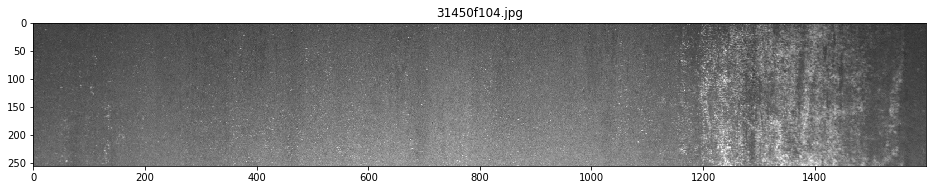

In [478]:
imshow(train_images[0])

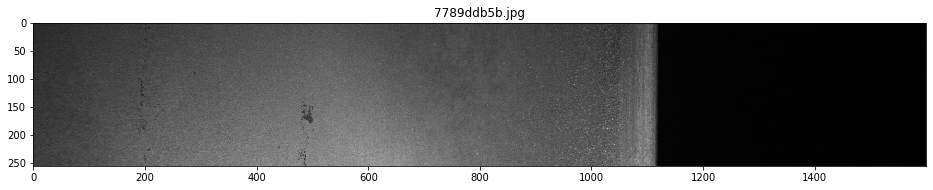

In [479]:
imshow(train_images[100])

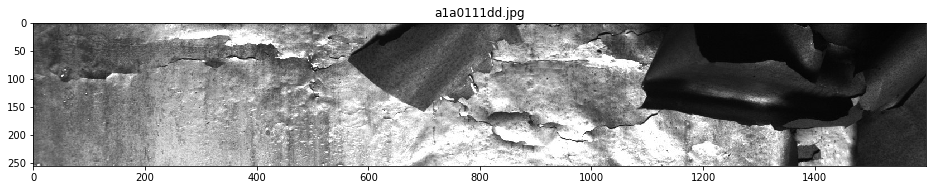

In [480]:
imshow(train_images[1000])

### Convert pixel index to position (row, column)

Instead of using the encoded pixel values, decode the given encodings to the respective pixel coordinates.

In [481]:
labels0.iloc[0].EncodedPixels[:5]

[(29102, 12), (29346, 24), (29602, 24), (29858, 24), (30114, 24)]

In [482]:
def run_length_to_coor(row: list) -> list:
    """Convert row of (pixel index, run length) to (pixel index, pixel index + run_length)"""
    return [(pos, (pos + length)) for (pos, length) in row]

def pixel_ix_to_rc(pixel_ix: int) -> tuple:
    """ 
    Convert pixel index to (row, column) tuple
    - pixel indexes are numbered top to bottom, left to right
    """
    global h
    global w

    row = pixel_ix % h
    column = pixel_ix // h
    return row, column

def single_pixel_runs(pixel: tuple) -> np.arange:
    """Decode (pixel index, run length) to `np.arange` of pixel indexes"""
    (ix, run) = pixel
    return np.arange(ix, ix+run+1)

def pixel_runs(row: list) -> np.array:
    """Apply `single_pixel_runs` to all values in the provided `row`"""
    return np.array(list(map(single_pixel_runs, row)))

def encoded_pixel_to_rc_list(encoded_pixel: tuple) -> list:
    """Given an encoded pixel (pixel ix, run length), return a list of pixel coordinates"""
    return list(map(pixel_ix_to_rc, single_pixel_runs(encoded_pixel)))

In [483]:
def flatten(ls: list) -> list:
    output = list()
    for l in ls:
        if isinstance(l, list):
            output += flatten(l)
        else:
            output.append(l)
    return output

assert [1, 2, 3] == flatten([1,[2, 3]])
assert [1, 2, 3] == flatten([[1], 2, [3]])
assert [1, 2, 3] == flatten([[[1, 2], [3]]])
assert [1, 2, 3, 4] == flatten([[1,[2]],3, [4]])
assert [1, 2, 3, 4, 5] == flatten([[[1], [2, [3], [[[4], 5]]]]])

...The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc...

Because Python indexes start at 0: (1, 1) => (0, 0); (2, 1) => (1, 0)

In [484]:
print(pixel_ix_to_rc(0))
assert pixel_ix_to_rc(0) == (0,0)

(0, 0)


In [485]:
print(pixel_ix_to_rc(1))
assert pixel_ix_to_rc(1) == (1, 0)

(1, 0)


In [486]:
last_pixel = (h * w) - 1
print(f"Height: {h}, Width: {w}")
print(f"Last Pixel Coordinate: ({h-1}, {w-1})")
print(pixel_ix_to_rc(last_pixel))
assert pixel_ix_to_rc(last_pixel) == (h-1, w-1)

Height: 256, Width: 1600
Last Pixel Coordinate: (255, 1599)
(255, 1599)


In [487]:
print(h, w)
pixel_ix_to_rc(1000)

256 1600


(232, 3)

## Group Images and Labels

In [488]:
def get_img_ix_by_fname(fname) -> int:
    """ Search for an image index  by filename (or partial filename) """
    global train_images
    return train_images.index([img_fname for img_fname in train_images 
                               if re.search(fname, img_fname)][0])

In [489]:
os.path.basename(train_images[42])

'4576c4722.jpg'

In [490]:
get_img_ix_by_fname('4576c')

42

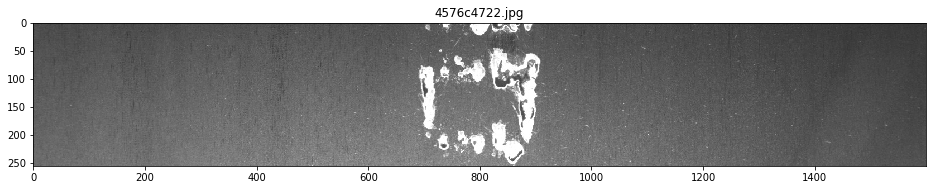

In [491]:
imshow(train_images[42])

In [492]:
def get_image_and_labels(ix: int) -> tuple:
    """
    Given an index, return training image and 4 rows of training labels for that image
    The given index is for the training images set. The training labels set has four rows
    per image, so the given image index needs to be converted to the associated labels
    
    Return the image filename, the image array, and the respective labels
    """
    global train_labels
    global train_images
    label_ix = ix * 4
    output_labels = train_labels.iloc[label_ix:label_ix + 4]
    output_labels = output_labels.assign(Coordinates = output_labels
                                                      .EncodedPixels
                                                      .apply(lambda row: [encoded_pixel_to_rc_list(pixel)
                                                                          for pixel in row]))
    fname = output_labels.ImageName.iloc[0]
    image_ix = get_img_ix_by_fname(fname)
    full_fname = train_images[image_ix]
    return (full_fname,
            imageio.imread(full_fname), 
            output_labels)

In [493]:
name0, img0, labels0 = get_image_and_labels(0)
os.path.basename(name0)

'0002cc93b.jpg'

In [494]:
labels0

ImageId_ClassId                                      EncodedPixels  \
0  0002cc93b.jpg_1  [(29102, 12), (29346, 24), (29602, 24), (29858...   
1  0002cc93b.jpg_2                                                 []   
2  0002cc93b.jpg_3                                                 []   
3  0002cc93b.jpg_4                                                 []   

   HasDefect  LabelIndex  ImageName  \
0       True           0  0002cc93b   
1      False           0  0002cc93b   
2      False           0  0002cc93b   
3      False           0  0002cc93b   

                                         Coordinates  
0  [[(174, 113), (175, 113), (176, 113), (177, 11...  
1                                                 []  
2                                                 []  
3                                                 []

In [495]:
name1, img1, labels1 = get_image_and_labels(100)
labels1

ImageId_ClassId EncodedPixels  HasDefect  LabelIndex  ImageName  \
400  01e69cfc3.jpg_1            []      False         100  01e69cfc3   
401  01e69cfc3.jpg_2            []      False         100  01e69cfc3   
402  01e69cfc3.jpg_3            []      False         100  01e69cfc3   
403  01e69cfc3.jpg_4            []      False         100  01e69cfc3   

    Coordinates  
400          []  
401          []  
402          []  
403          []

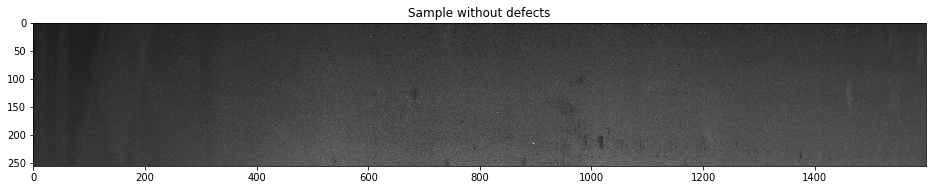

In [496]:
plt.imshow(img1)
plt.title("Sample without defects")
None

In [497]:
name1000, img1000, labels1000 = get_image_and_labels(1000)
labels1000

ImageId_ClassId                                      EncodedPixels  \
4000  14fb9778c.jpg_1                                                 []   
4001  14fb9778c.jpg_2                                                 []   
4002  14fb9778c.jpg_3  [(88514, 63), (88644, 189), (88837, 252), (890...   
4003  14fb9778c.jpg_4                                                 []   

      HasDefect  LabelIndex  ImageName  \
4000      False        1000  14fb9778c   
4001      False        1000  14fb9778c   
4002       True        1000  14fb9778c   
4003      False        1000  14fb9778c   

                                            Coordinates  
4000                                                 []  
4001                                                 []  
4002  [[(194, 345), (195, 345), (196, 345), (197, 34...  
4003                                                 []

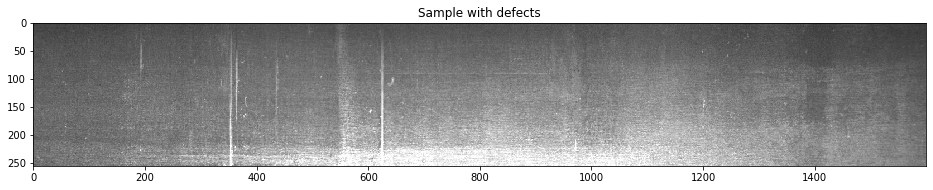

In [498]:
plt.imshow(img1000)
plt.title("Sample with defects")
None

---

## Which Images have defects?

In [499]:
def get_defect_indexes() -> list:
    global train_labels
    return list(set(train_labels[train_labels.HasDefect == True].LabelIndex))

In [500]:
get_defect_indexes()[:10]

[0, 4, 5, 6, 7, 11, 12, 14, 15, 17]

In [501]:
name17, img17, labels17 = get_image_and_labels(17)
labels17

ImageId_ClassId                                      EncodedPixels  \
68  0046839bd.jpg_1                                                 []   
69  0046839bd.jpg_2                                                 []   
70  0046839bd.jpg_3  [(152926, 1), (153180, 4), (153434, 6), (15368...   
71  0046839bd.jpg_4                                                 []   

    HasDefect  LabelIndex  ImageName  \
68      False          17  0046839bd   
69      False          17  0046839bd   
70       True          17  0046839bd   
71      False          17  0046839bd   

                                          Coordinates  
68                                                 []  
69                                                 []  
70  [[(94, 597), (95, 597)], [(92, 598), (93, 598)...  
71                                                 []

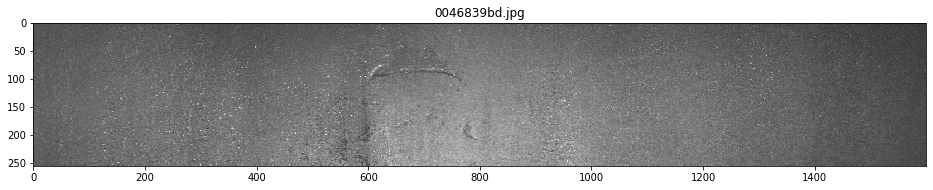

In [502]:
img17_ix = get_img_ix_by_fname(labels17.ImageName.iloc[0])
imshow(train_images[img17_ix])

In [503]:
def get_defectless_indexes() -> list:
    global train_labels
    return list(set(train_labels[train_labels.HasDefect == False].LabelIndex))

In [504]:
get_defectless_indexes()[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [505]:
name9, img9, labels9 = get_image_and_labels(9)
labels9

ImageId_ClassId EncodedPixels  HasDefect  LabelIndex  ImageName  \
36  001d1b355.jpg_1            []      False           9  001d1b355   
37  001d1b355.jpg_2            []      False           9  001d1b355   
38  001d1b355.jpg_3            []      False           9  001d1b355   
39  001d1b355.jpg_4            []      False           9  001d1b355   

   Coordinates  
36          []  
37          []  
38          []  
39          []

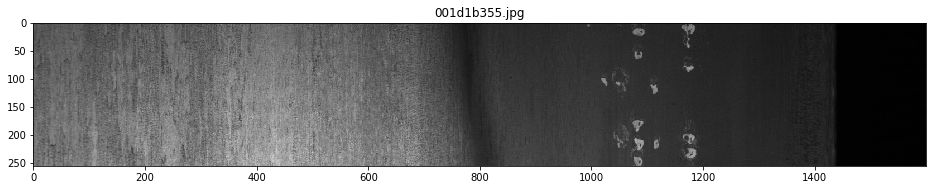

In [506]:
img9_ix = get_img_ix_by_fname(labels9.ImageName.iloc[0])
imshow(train_images[img9_ix])

## Showing Defects in the Training Images

In [507]:
def defect_mask(img, labels):
    """ 
    Mask the given image using its labels feature `EncodedPixels`
    
    Return the defect mask 
    """
    global h
    global w
    mask = np.zeros((h, w, 4), np.uint8)
    for i in range(4):
        class_mask = np.zeros(h*w, np.uint8)
        for defect in labels.EncodedPixels.iloc[i]:
            pos, length = defect
            class_mask[pos:pos+length] = 255
            
        mask[:,:,i] = class_mask.reshape(h, w, order='F') # tricky, order='F'
        
    return mask

def defect_contour(img, mask):
    contour_img = np.copy(img)
    # a color for each class
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    for i, color in enumerate(colors):
        contours, _ = cv2.findContours(mask[:, :, i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(contour_img, contours[i], True, color, 2)
        
    return contour_img, contours

def show_defect(img, labels):
    """ Show image with outline of any defect(s) """
    mask = defect_mask(img, labels)
    contoured_img, _ = defect_contour(img, mask)
    plt.title(labels.ImageName.iloc[0])
    plt.imshow(contoured_img)

---

In [508]:
x = np.arange(15)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [509]:
x.reshape((3, 5)) # order='C'

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

In [510]:
x.reshape((3, 5), order='A')

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

In [511]:
x.reshape((3, 5), order='F')

array([[ 0,  3,  6,  9, 12],
       [ 1,  4,  7, 10, 13],
       [ 2,  5,  8, 11, 14]])

_...The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc..._

Starting with a (1xN) array, reshaping using `order='F'` seems to provide suitable ordering - top to bottom, left to right.

---

In [512]:
name, img, labels = get_image_and_labels(0)
labels

ImageId_ClassId                                      EncodedPixels  \
0  0002cc93b.jpg_1  [(29102, 12), (29346, 24), (29602, 24), (29858...   
1  0002cc93b.jpg_2                                                 []   
2  0002cc93b.jpg_3                                                 []   
3  0002cc93b.jpg_4                                                 []   

   HasDefect  LabelIndex  ImageName  \
0       True           0  0002cc93b   
1      False           0  0002cc93b   
2      False           0  0002cc93b   
3      False           0  0002cc93b   

                                         Coordinates  
0  [[(174, 113), (175, 113), (176, 113), (177, 11...  
1                                                 []  
2                                                 []  
3                                                 []

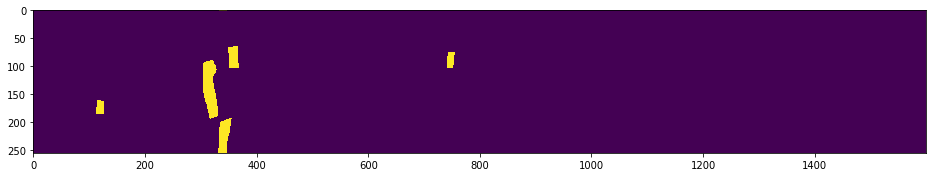

In [513]:
mask = defect_mask(img, labels)
plt.imshow(mask[:,:,0])
None

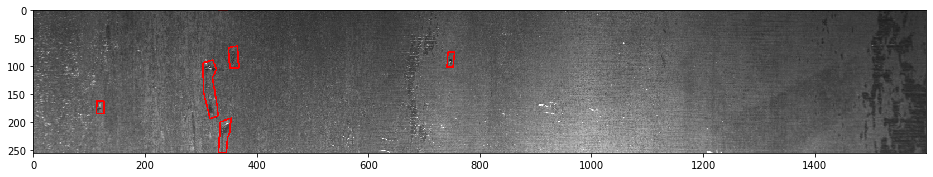

In [514]:
contoured_img, _ = defect_contour(img, mask)
plt.imshow(contoured_img)
None

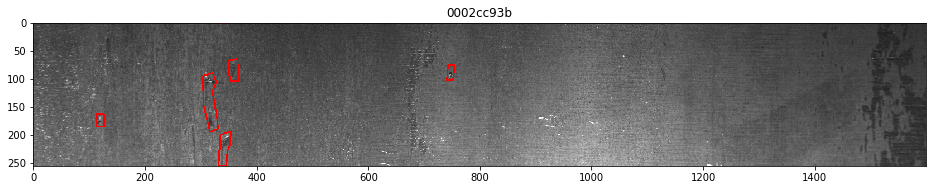

In [515]:
show_defect(img, labels)

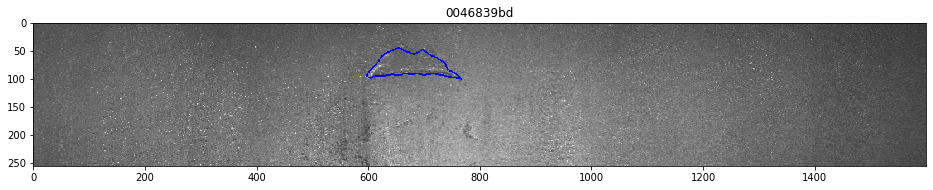

In [516]:
show_defect(img17, labels17)

In [517]:
name7940, img7940, labels7940 = get_image_and_labels(7940)
name7940

'/home/jeremy/programming/datasets/severstal-steel-defect-detection/train_images/a1a0111dd.jpg'

In [518]:
labels7940

ImageId_ClassId EncodedPixels  HasDefect  LabelIndex  ImageName  \
31760  a1a0111dd.jpg_1            []      False        7940  a1a0111dd   
31761  a1a0111dd.jpg_2            []      False        7940  a1a0111dd   
31762  a1a0111dd.jpg_3            []      False        7940  a1a0111dd   
31763  a1a0111dd.jpg_4            []      False        7940  a1a0111dd   

      Coordinates  
31760          []  
31761          []  
31762          []  
31763          []

---

## Which images have more than one type of defect?

In [519]:
multiple_class_defects = list()
for ix in get_defect_indexes():
    labels = train_labels[train_labels.LabelIndex == ix]
    defect_filter = filter(bool, labels.EncodedPixels)
    if len(list(defect_filter)) > 1:
        multiple_class_defects.append(ix)

In [520]:
multiple_class_defects[:10]

[11, 14, 34, 37, 44, 64, 93, 174, 185, 201]

In [521]:
name, img, labels = get_image_and_labels(11)
labels

ImageId_ClassId                                      EncodedPixels  \
44  0025bde0c.jpg_1                                                 []   
45  0025bde0c.jpg_2                                                 []   
46  0025bde0c.jpg_3  [(8458, 14), (8707, 35), (8963, 48), (9219, 71...   
47  0025bde0c.jpg_4  [(315139, 8), (315395, 15), (315651, 16), (315...   

    HasDefect  LabelIndex  ImageName  \
44      False          11  0025bde0c   
45      False          11  0025bde0c   
46       True          11  0025bde0c   
47       True          11  0025bde0c   

                                          Coordinates  
44                                                 []  
45                                                 []  
46  [[(10, 33), (11, 33), (12, 33), (13, 33), (14,...  
47  [[(3, 1231), (4, 1231), (5, 1231), (6, 1231), ...

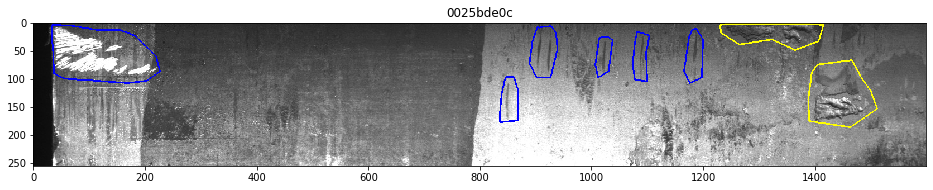

In [522]:
show_defect(img, labels)

In [523]:
name, img, labels = get_image_and_labels(201)
labels

ImageId_ClassId                                      EncodedPixels  \
804  044700866.jpg_1                                                 []   
805  044700866.jpg_2                                                 []   
806  044700866.jpg_3  [(142219, 15), (142475, 45), (142731, 75), (14...   
807  044700866.jpg_4  [(101, 63), (357, 64), (613, 66), (869, 67), (...   

     HasDefect  LabelIndex  ImageName  \
804      False         201  044700866   
805      False         201  044700866   
806       True         201  044700866   
807       True         201  044700866   

                                           Coordinates  
804                                                 []  
805                                                 []  
806  [[(139, 555), (140, 555), (141, 555), (142, 55...  
807  [[(101, 0), (102, 0), (103, 0), (104, 0), (105...

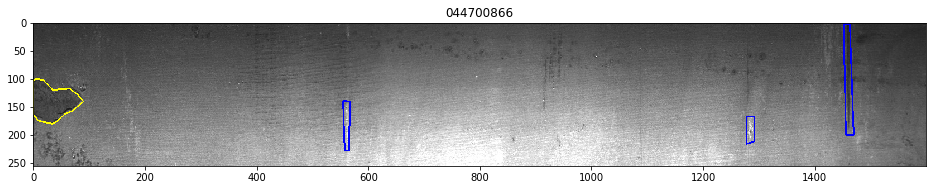

In [524]:
show_defect(img, labels)

In [525]:
name, img, labels = get_image_and_labels(11776)
labels

ImageId_ClassId                                      EncodedPixels  \
47104  ef24da2ba.jpg_1  [(366699, 32), (366955, 32), (367210, 33), (36...   
47105  ef24da2ba.jpg_2  [(366338, 17), (366594, 50), (366850, 82), (36...   
47106  ef24da2ba.jpg_3  [(178369, 64), (178498, 191), (178690, 255), (...   
47107  ef24da2ba.jpg_4                                                 []   

       HasDefect  LabelIndex  ImageName  \
47104       True       11776  ef24da2ba   
47105       True       11776  ef24da2ba   
47106       True       11776  ef24da2ba   
47107      False       11776  ef24da2ba   

                                             Coordinates  
47104  [[(107, 1432), (108, 1432), (109, 1432), (110,...  
47105  [[(2, 1431), (3, 1431), (4, 1431), (5, 1431), ...  
47106  [[(193, 696), (194, 696), (195, 696), (196, 69...  
47107                                                 []

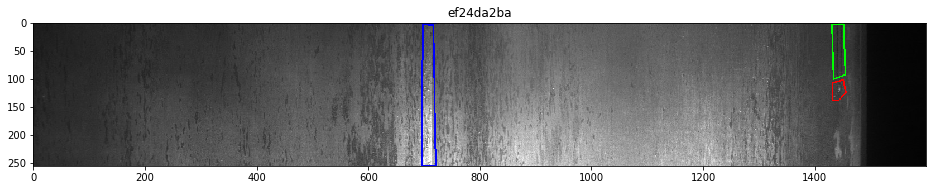

In [526]:
show_defect(img, labels)

In [527]:
name, img, labels = get_image_and_labels(10803)
labels

ImageId_ClassId                                      EncodedPixels  \
43212  db4867ee8.jpg_1  [(349941, 2), (350194, 6), (350447, 11), (3507...   
43213  db4867ee8.jpg_2  [(354411, 17), (354634, 50), (354857, 82), (35...   
43214  db4867ee8.jpg_3                     [(233729, 3008), (236801, 64)]   
43215  db4867ee8.jpg_4                                                 []   

       HasDefect  LabelIndex  ImageName  \
43212       True       10803  db4867ee8   
43213       True       10803  db4867ee8   
43214       True       10803  db4867ee8   
43215      False       10803  db4867ee8   

                                             Coordinates  
43212  [[(245, 1366), (246, 1366), (247, 1366)], [(24...  
43213  [[(107, 1384), (108, 1384), (109, 1384), (110,...  
43214  [[(1, 913), (2, 913), (3, 913), (4, 913), (5, ...  
43215                                                 []

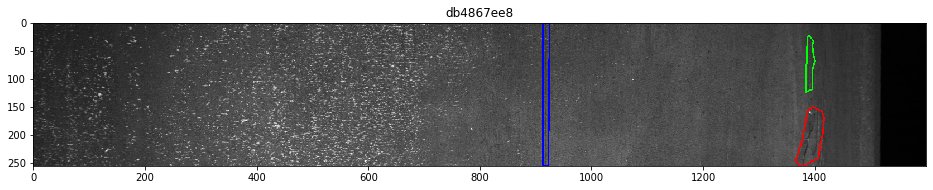

In [528]:
show_defect(img, labels)